## Evaluate the current status of the nanocosms

all data are imported and summarized then a panel with all trajectories is created.

In [1]:
import os; os.chdir("..")  # change into root of working directory
import sys; sys.path.append("src")  # add src to system path and allow packages to be found
import pandas as pd
import itertools as it
import numpy as np
from matplotlib import pyplot as plt
import evaluation.calc as calc
from image.analysis import Data

In [2]:
rawdata = Data.combine_data_classic(
    datapath="data/",
    interpolation_cfg={"method":"pad", "limit":1, "limit_direction":"forward"})
rawdata.fillna(0, inplace=True)

The next steps boil the data down

In [3]:
# get count of organisms for each picture and each analysis
groups = ["id","picture", "species", "analysis","culex_larvae",
          "culex_adults", "culex_pupae", "culex_repro", "sediment"]
d = calc.aggregate(
    rawdata, 
    aggregations={"hash":"size", "value":"mean"}, 
    names=["count", "mean_size"],
    freq="S", groups=groups)

# get sum of analyses for each picture and species
groups = [g for g in groups if g != "analysis"] # remove picture from group list
d = calc.aggregate(
    d, {"count":"sum", "mean_size": "mean"}, names=[],
    freq="S", groups=groups )

# get sum of analyses for each picture and species
groups = [g for g in groups if g != "picture"] # remove picture from group list
d = calc.aggregate(
    d, {"count":"max", "mean_size": "mean"}, names=["count"],
    freq="D", groups=groups )

# replace culex abundance calculated by the algorithm by manually counted number of cu
d.reset_index(inplace=True)
d["count"] = np.where(((d["time"] == "2021-04-09") | (d["time"] == "2021-04-16")) & (d["species"] == "Culex"), d["culex_larvae"], d["count"])

d
# d.query("time == '2021-04-06'")

# d["larvae"] = np.where((d["time"] == "2021-04-09" | d["time"] == "2021-04-06") & d["species"] == "Culex", d["culex_larvae"], d["count"])
# d["larvae"] = np.where(pdat["time"] == "2021-04-16", pdat["culex_larvae"], pdat["count"])
# pdat["culex"] = pdat["larvae"] + pdat["culex_adults"] + pdat["culex_pupae"]
# # pdat["culex"] = np.where(pdat["id"] == 34, 10, pdat["culex"])
# pdat.rename(columns={"culex_adults":"adults", "culex_pupae":"pupae"}, inplace=True)

,time,id,species,culex_larvae,culex_adults,culex_pupae,culex_repro,sediment,count,mean_size
0,2021-04-02,1,Culex,0.0,0.0,0.0,0.0,0.0,4.0,4.833333
1,2021-04-02,1,Daphnia,0.0,0.0,0.0,0.0,0.0,31.0,21.353747
2,2021-04-02,2,Culex,0.0,0.0,0.0,0.0,0.0,8.0,4.023810
3,2021-04-02,2,Daphnia,0.0,0.0,0.0,0.0,0.0,17.0,39.101062
4,2021-04-02,3,Culex,0.0,0.0,0.0,0.0,0.0,11.0,5.133333
...,...,...,...,...,...,...,...,...,...,...
795,2021-04-16,78,Daphnia,9.0,2.0,0.0,0.0,1.0,26.0,34.895469
796,2021-04-16,79,Culex,3.0,1.0,1.0,0.0,1.0,3.0,4.083333
797,2021-04-16,79,Daphnia,3.0,1.0,1.0,0.0,1.0,7.0,20.392857
798,2021-04-16,80,Culex,16.0,0.0,0.0,0.0,1.0,16.0,3.875000


plot panels with trajectories of culex. Dates, where larvae counts of the image detection are exchanged with manual larvae counts have to be manually specified.

Text(0, 0.5, 'Culex')

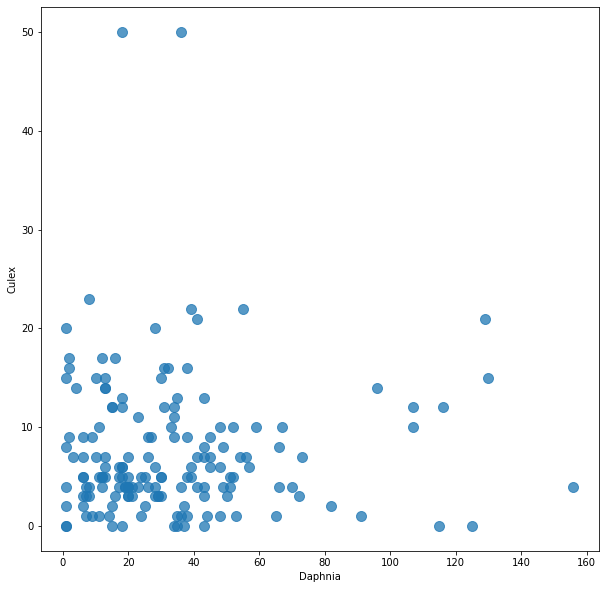

In [4]:
data = d.reset_index()[["time", "species", "count","id"]].rename(columns={"count":"y"}).query("time == '2021-04-09' | time == '2021-04-16'")
species = np.array(data.species)
daphnia = np.array(data.y)[species=="Daphnia"]
culex = np.array(data.y)[species=="Culex"]
g = np.where(np.array(data.id)[species=="Culex"] <= 40, 0, 1)
# o2 = np.array(data.oxygen)
# print(daphnia)
# print(culex)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(daphnia, culex, c="tab:blue", alpha=.75, s=100)
ax.set_xlabel("Daphnia")
ax.set_ylabel("Culex")
# ax.set_ylim(0,20)
# ax.set_xlim(0,200)

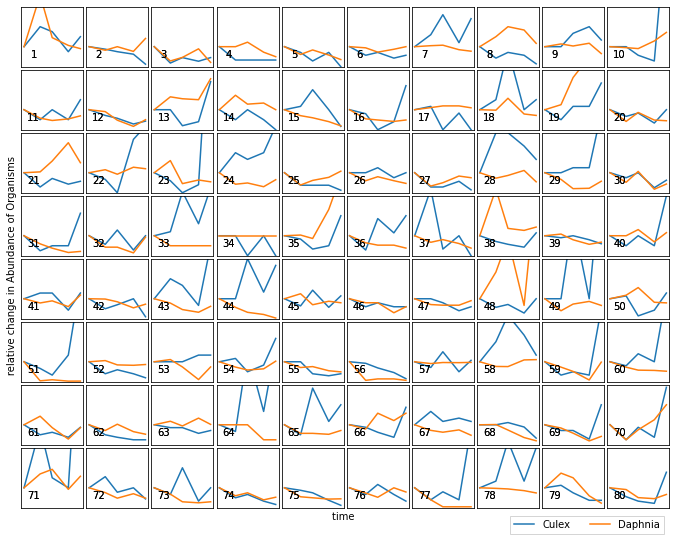

In [5]:

# plot relative changes of CUlex and Daphnia
fig, axes = plt.subplots(figsize=(10,8), ncols=10, nrows=8, sharex=True, sharey=True)
axes = axes.flatten()
pdat = d.reset_index()
lines = []
for ax, i in zip(axes, np.arange(1, 81)):
    dd = pdat.query("id == @i")
    spcs = dd["species"].unique()
    for s in spcs:
        ddd = dd.query("species == @s").reset_index()
        cnt_percent = ddd["count"] / ddd["count"][0]
        l, = ax.plot(ddd["time"], cnt_percent, label = s)
        ax.text(0.2, 0.2, str(i), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)        # ax.set_ylabel("Abundance")
        # ax.set_xlabel("Time")
        ax.set_ylim(0,3)
        ax.set_xticks([])
        ax.set_yticks([])
        lines.append(l)

fig.subplots_adjust(bottom=0.08, wspace=0.05, hspace=0.05, top=.95, right=0.95, left=0.05)

axes[79].legend(handles = lines[:2], labels=list(spcs), loc='upper right', 
                bbox_to_anchor=(1, -0.05),fancybox=False, shadow=False, ncol=2)
axes[75].set_xlabel("time                      ")
axes[40].set_ylabel("               relative change in Abundance of Organisms")

plt.show()


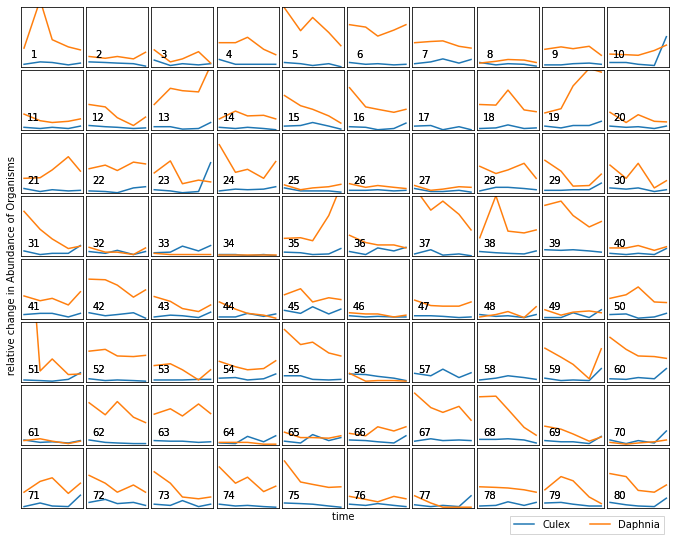

In [6]:

# plot relative changes of CUlex and Daphnia
fig, axes = plt.subplots(figsize=(10,8), ncols=10, nrows=8, sharex=True, sharey=True)
axes = axes.flatten()
pdat = d.reset_index()
lines = []
for ax, i in zip(axes, np.arange(1, 81)):
    dd = pdat.query("id == @i")
    spcs = dd["species"].unique()
    for s in spcs:
        ddd = dd.query("species == @s").reset_index()
        cnt_percent = ddd["count"]
        l, = ax.plot(ddd["time"], cnt_percent, label = s)
        ax.text(0.2, 0.2, str(i), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)        # ax.set_ylabel("Abundance")
        # ax.set_xlabel("Time")
        ax.set_ylim(0,100)
        ax.set_xticks([])
        ax.set_yticks([])
        lines.append(l)

fig.subplots_adjust(bottom=0.08, wspace=0.05, hspace=0.05, top=.95, right=0.95, left=0.05)

axes[79].legend(handles = lines[:2], labels=list(spcs), loc='upper right', 
                bbox_to_anchor=(1, -0.05),fancybox=False, shadow=False, ncol=2)
axes[75].set_xlabel("time                      ")
axes[40].set_ylabel("               relative change in Abundance of Organisms")

plt.show()
